in future this function will be depricated... 
 use read_twocolfile instead


C:\Users\Arun\Anaconda3\Lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


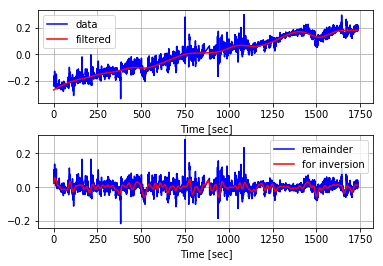

C:\Users\Arun\Anaconda3\Lib\site-packages\scipy\signal\signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
C:\Users\Arun\Anaconda3\Lib\site-packages\scipy\signal\signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]


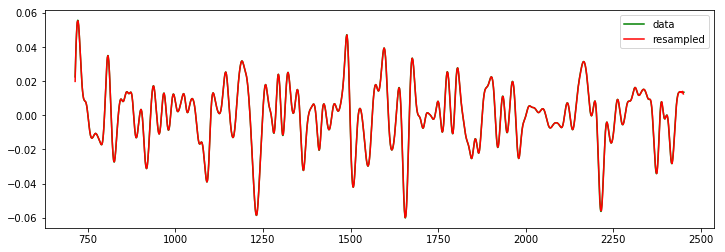

In [1]:
from petrel_well_file_readers import *
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import lasio
from flex_log import FlexXY,FlexLog
from seis_ampl_spectrum import *
folder=r'D:\SoftwareWebApps\Python\geophysics\inversion&spect_decomp\d11_data\\'
# folder=r"D:\Ameyem\python\inversion&spectraldecomp\d11_data\\"
las_file=folder+'nec25_a1.las'
las=lasio.read(las_file)

chkt_file=folder+"nec25_a1_chkt.dat"
chkt=read_chkt(chkt_file)
X=chkt['MD'].values
X.shape=len(X),1
y=chkt['TWT picked'].values
md2twt = LinearRegression().fit(X, y)

las=lasio.read(las_file)
flexlog = FlexLog(np.array([[0,0]]))
x,y=las['DEPT'],las['AI']
x,y=flexlog.get_nonanXYs(x,y)
# plt.plot(x,y)

#seismic trace
from petrel_well_file_readers import *
file=folder+'nec25_a1_NORTH_SEIS.dat'
seis_signal=read_tworowfile(file,nheadrows=2)
seisflexlog = FlexLog(np.column_stack((seis_signal['TWT'],seis_signal['Trace'])))
def norm(x):
    return (x - np.mean(x)) / np.std(x)
from bruges.filters import ricker as ricker_
FS = 1/0.002
def ricky(length, width):
    return ricker_(0.256, 1/FS, width)

wavelet=ricky(400,20)
dt=2
freq, amp=ampspec(wavelet.T,dt)
f_peak = freq[np.argmax(amp)]
from scipy import signal

md=x
md.shape=len(md),1
twt=md2twt.predict(md)
t=-twt+twt[0]

dt=np.mean(np.diff(t))

nclip=0
# t=-twt[nclip:]+twt[nclip:][0]

# a=np.array([4587.4941406 , 4722.09412164, 4796.70790784])
# a[::-1]
n=len(t)
dt=np.mean(np.diff(t))
T=t[-1]/1000
fs=n/T

t=-twt[nclip:]+twt[nclip:][0]
# data=norm(y[nclip:])
maxai=max(y[nclip:])
data=y[nclip:]/maxai
meanai=np.mean(data)
data=data-meanai

# data=data/max(data)




fc = 5  # Cut-off frequency of the filter
w = fc / (fs / 2) # Normalize the frequency
order=3
b, a = signal.butter(order, w, 'low')
output = signal.filtfilt(b, a, data)
plt.subplot(2, 1, 1)
plt.plot(t, data, 'b-', label='data')
plt.plot(t, output,'r-', label='filtered')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()
########################################################
data=data-output #removing low frequency component
########################################################
fc = 40  # Cut-off frequency of the filter 70 gave 36%, 12.6ms bs
w = fc / (fs / 2) # Normalize the frequency
b, a = signal.butter(order, w, 'low')
ai_for_inv = signal.filtfilt(b, a, data)

plt.subplot(2, 1, 2)
plt.plot(t, data, 'b-', label='remainder')
plt.plot(t, ai_for_inv,'r-', label='for inversion')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

from scipy import signal

new_tstart=np.ceil(t[0]+(-twt[0])) # time need to match with seismic time 
if new_tstart%2!=0:
    new_tstart+=1
    

sample_start=new_tstart-(-twt[0])
###############################################################
x,y=t,ai_for_inv #making removed high frequency signal as main
# x,y=t,data
###############################################################
# x = np.linspace(0, 10, 20, endpoint=False)
# y = np.cos(-x**2/6.0)
def nresamples(x,present_dt,req_dt):
    return int(len(x) / (req_dt * present_dt))
def myresample(x,y,sample_start=0,dt=4):
    xnew=np.arange(sample_start,x[-1]+0.001,dt)
    res_y = signal.resample(y, len(xnew))
    return xnew,res_y

import matplotlib.pyplot as plt
tnew,ai_res=myresample(x,y,dt=2)
tnew=tnew+new_tstart
x=x+new_tstart
plt.figure(figsize=(12,4))
# plt.plot(t, data, 'y-')
plt.plot(x, y, 'g-', tnew, ai_res, 'r-')
# plt.plot(x, y, 'go-', xnew, f, '.-', 10, y[0], 'ro')
plt.legend(['data', 'resampled'], loc='best')
plt.show()


In [ ]:
lai=ai_for_inv+output
rec_ai=(lai+meanai)*maxai
# t-twt[0],tnew
plt.plot(t-twt[0],rec_ai,'.r')
ai_flex=FlexLog(np.column_stack((t-twt[0],rec_ai)))
ai_res=ai_flex.resampleXYs(tnew)
plt.plot(ai_res[:,0],ai_res[:,1])

In [ ]:
tnew
rc=(ai_res[1:,1]-ai_res[:-1,1])/(ai_res[1:,1]+ai_res[:-1,1])
seis_data=seisflexlog.resampleXYs(tnew)
plt.subplot(2, 1, 1)
plt.plot(tnew[:-1], rc, 'b-', label='RC')
# plt.plot(ai_res[:,0],ai_res[:,1])
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(tnew, seis_data[:,1], 'r-', label='seis_data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

np.save('d11_t_ai_rc_seis.npy',(tnew[:-1],ai_res[:-1,1],rc,seis_data[:-1,1]))